# Modeule 1, Example 1: Farmer's Problem
**Petrobras Course on Stochastic Optimization**\
Instructors: Steve Gabriel \& Dominic Flocco\
Date: October 2024
## Step 0: Install Code Dependencies

Before we get started, run the following cells to load the necessary Python packages for the notebook and some helper functions we'll use to display model solutions.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.mpec import *
pd.set_option('display.float_format', '{:.2f}'.format)

# set solver
opt = SolverFactory('glpk')

In [26]:
# Helper function to pprint solution after det_model solve
def print_det_solution(det_model):
    print(f"========== {det_model.name} Solution Report ===========")
    print(f"\n******** FARMERS PROFIT = ${-det_model.objective():.2f} ")
    # Store model results in dictionary
    result_dict = {'Surface (acres)': dict(),
                   'Yield (tons)': dict(),
                   'Sales (tons)': dict(),
                   'Purchase (tons)': dict()}
    for crop in det_model.crops:
        result_dict['Surface (acres)'][crop] = det_model.acres[crop].value
        result_dict['Yield (tons)'][crop] = det_model.yields[crop].value*det_model.acres[crop].value

    result_dict['Sales (tons)']['sugar_beets'] = det_model.sold['sugar_beets_under_quota'].value \
                                                  + det_model.sold['sugar_beets_over_quota'].value
    result_dict['Sales (tons)']['wheat'] = det_model.sold['wheat'].value
    result_dict['Sales (tons)']['corn'] = det_model.sold['corn'].value

    result_dict['Purchase (tons)']['wheat'] = det_model.purchased['corn'].value
    result_dict['Purchase (tons)']['corn'] = det_model.purchased['corn'].value
    result_dict['Purchase (tons)']['sugar_beets'] = 0

    # Convert result dictionary to Pandas dataframe
    result_df = pd.DataFrame().from_dict(result_dict,
                                         orient='index',
                                         columns=det_model.crops)
    result_df.rename(columns={'wheat': 'Wheat', 'corn':'Corn', 'sugar_beets': 'Sugar Beets'},
                     inplace=True)
    return result_df

# Helper function to pprint solution after stoc_model solve
def print_stoc_solution(stoc_model):
    print(f"=========== {stoc_model.name} Solution Report =============")
    print(f"\n******** FARMERS PROFIT = ${-stoc_model.objective():.2f} ")
    result_dict = {('NA','Surface (acres)'): dict()}

    # Store first-stage decisions
    for crop in stoc_model.crops:
        result_dict[('NA','Surface (acres)')][crop] = stoc_model.acres[crop].value


    for s in stoc_model.scenarios:
        result_dict.update({(s,'Yield (tons)'): dict(),
                            (s,'Sales (tons)'): dict(),
                            (s,'Purchase (tons)'): dict()})
        for crop in stoc_model.crops:
            result_dict[(s,'Yield (tons)')][crop] = stoc_model.yields[crop,s].value*stoc_model.acres[crop].value

        result_dict[(s, 'Sales (tons)')]['sugar_beets'] = stoc_model.sold['sugar_beets_under_quota',s].value \
                                                            + stoc_model.sold['sugar_beets_over_quota',s].value
        result_dict[(s,'Sales (tons)')]['wheat'] = stoc_model.sold['wheat',s].value
        result_dict[(s, 'Sales (tons)')]['corn'] = stoc_model.sold['corn',s].value

        result_dict[(s,'Purchase (tons)')]['wheat'] = stoc_model.purchased['corn',s].value
        result_dict[(s,'Purchase (tons)')]['corn'] = stoc_model.purchased['corn',s].value
        result_dict[(s,'Purchase (tons)')]['sugar_beets'] = 0


    # Convert result dictionary to Pandas dataframe
    result_df = pd.DataFrame().from_dict(result_dict,
                                         orient='index',
                                         columns=stoc_model.crops)
    result_df.index = pd.MultiIndex.from_tuples(result_dict.keys(), names=['Scenario', 'Variable'])
    result_df.rename(columns={'wheat': 'Wheat', 'corn':'Corn', 'sugar_beets': 'Sugar Beets'},
                     inplace=True)
    return result_df





## Problem Description
Adapted from: Birge, J. R., & Louveaux, F. (2011). *Introduction to Stochastic Programming*. Springer Science & Business Media. Chapter 1

### Problem Statement
Consider a farmer who specializes in raising wheat, corn and sugar beets on his 500 acres of land. During the winter, he wants to decide how much land to devote to each crop. The farmer knows that at least 200 tons of wheat and 240 tons of corn are needed to feed his cattle. These amounts can be raised on the farm or bought from a wholesaler. Any production in excess of the feeding requirement would be sold. The purchase prices are 40% higher than the selling prices due to the wholesaler's margin and transportation. The other profitable crop the farmer has at his disposal is sugar beets, which he expects to sell at \\$36/ton. However, there is a quota on sugar beet production, which means any amount in excess of the quota can sold only at \\$10/ton. The farmer's quota for next year is 6000 tons.

Based on past experience, the farmer knows that the mean yield on his land is roughly 2.5 tons, 3 tons, and 20 tons per acre for wheat, corn and sugar beets, respectively. The following table summarizes the data inputs for the problem

|    | Wheat | Corn | Sugar Beets |
| -- | ----- | ---- | ----------- |
| Yield (ton/acre) | 2.5 | 3 | 20 |
| Planting cost (\\$/acre) | 150 | 230 | 260 |
| Selling price (\\$/ton) | 170 | 150| 36 under 6000 tons|
| | | | 10 above 6000 tons|
|Purchase price (\\$/ton) |238 | 210 |  |
| Minimum requirement (tons)| 200 | 240 | |

The farmer's goal is to maximize net profits while satisfying the feeding requirements for his cattle.

### Problem Formulation (Deterministic)
To formulate this problem as a linear program (LP), we'll use the following notation:

- $x_1$: acres of land devoted to wheat,
- $x_2$: acres of land devoted to corn,
- $x_3$ acres of land devoted to sugar beets,
- $w_1$ tons of wheat sold,
- $y_1$: tons of wheat purchased,
- $w_2$: tons of corn sold,
- $y_2$: tons of corn purchased,
- $w_3$: tons of sugar beets sold at the favorable price (under quota)
- $w_4$: tons of sugar beets sold at the lower price (over quota)

Using the data above, the LP formulation in the deterministic setting is:


\begin{align}
  \min \quad & 150x_1 + 230x_2 + 260x_3 & \text{Planting costs}\\
              & +238y_1 + 210y_2 & \text{Purchase costs}\\
              & - (170w_1 + 150w_2 - 26w_3 - 10w_4) & \text{Revenues}\\
  \text{s.t.}\quad & x_1 + x_2 + x_3 \leq 500 & \text{Total land available} \\
  & 2.5x_1 + y_1 - w_1 \geq 200 & \text{Wheat min. requirement}\\
  & 3x_2 + y_2 - w_2 \geq 240 & \text{Corn min. requirement}\\
  & w_3 + w_4 - 20x_3 \leq 0 & \text{Sugar beets}\\
  & w_3 \leq 600 & \text{1st part of quota}\\
  &x_1, x_2, x_3,w_1,y_1,w_2,y_2, w_3,w_4 \geq 0 & \text{Nonnegativity}
  \end{align}



## Deterministic Model Implementation
We will implement the Farmer's problem LP using [`Pyomo`](https://pyomo.readthedocs.io/en/stable/). Run the cells below to formulate and solve the model.

### Deterministic Model Creation in Pyomo

In [3]:
# load problem data
planting_costs = {'wheat': 150,
                  'corn': 230,
                  'sugar_beets': 260}
selling_prices = {'wheat': 170,
                  'corn': 150,
                  'sugar_beets_under_quota': 36,
                  'sugar_beets_over_quota':10}
purchase_prices = {'wheat': 238,
                   'corn': 210}
minimum_reqs = {'wheat': 200,
                'corn': 240}
mean_yields = {'wheat': 2.5,
                'corn': 3,
                'sugar_beets': 20}
sugar_beets_quota = 6000
total_land = 500

In [4]:
# initialize Pyomo model object
det_model = ConcreteModel(name="Deterministic Farmer's Problem")

# set det_model parameters and sets
det_model.crops = Set(initialize=['wheat', 'corn','sugar_beets'])

# crop yields per acre (tons/acre)
det_model.yields = Param(det_model.crops,
                   mutable=True, # let's us change the value later
                   initialize=mean_yields)

# planting costs (USD/acre)
det_model.planting_cost = Param(det_model.crops,
                            initialize=planting_costs)
# selling price in market (USD/ton)
det_model.selling_price = Param(['wheat', 'corn',
                             'sugar_beets_under_quota',
                             'sugar_beets_over_quota'],
                            initialize=selling_prices)

# first part of sugar beets quota
det_model.sugar_beets_quota = Param(initialize=sugar_beets_quota) # tons

# purchasing price at wholesaler
det_model.purchase_price = Param(['wheat', 'corn'],
                             initialize=purchase_prices) # USD/ton

# minimum requirement to feed cattle
det_model.minimum_req = Param(['wheat','corn'],
                          initialize=minimum_reqs) # acres
# total available acres
det_model.total_land = Param(initialize=total_land) # acres


In [5]:
# declare deterministic model variables
det_model.acres = Var(det_model.crops, # acres
                  within=NonNegativeReals)

det_model.sold = Var(['wheat', 'corn',
                  'sugar_beets_under_quota',
                  'sugar_beets_over_quota'], # tons
                 within=NonNegativeReals)

det_model.purchased = Var(['wheat', 'corn'], # tons
                      within=NonNegativeReals)


In [6]:
# set det_model constraints

# total land available constraint:
#   acres of wheat + acres of corn + acres of sugar_beets <= 500
det_model.total_land_constraint = Constraint(expr=sum(det_model.acres[crop] for crop in det_model.crops) <= det_model.total_land)

# wheat minimum requirement constraint:
#   yield + amount purchased - amount sold >= 200
det_model.wheat_min_req_constraint = Constraint(expr=det_model.yields['wheat'] * det_model.acres['wheat'] + det_model.purchased['wheat']\
                                                    - det_model.sold['wheat'] >= det_model.minimum_req['wheat'])

# corn minimum requirement constraint:
#   yield + amount purchased - amount sold >= 240
det_model.corn_min_req_constraint = Constraint(expr=det_model.yields['corn'] * det_model.acres['corn'] + det_model.purchased['corn']\
                                                    - det_model.sold['corn'] >= det_model.minimum_req['corn'])

# sugar beets selling constraint:
#   sugar_beets sold <= sugar_beet yield
det_model.sugar_beets_sold_constraint = Constraint(expr=det_model.sold['sugar_beets_under_quota'] + det_model.sold['sugar_beets_over_quota']\
                                                        <= det_model.yields['sugar_beets']*det_model.acres['sugar_beets'])

# sugar beets first quota constraint:
#   sugar_beets sold for under quota price <= 6000
det_model.sugar_beets_quota_constraint = Constraint(expr=det_model.sold['sugar_beets_under_quota'] <= det_model.sugar_beets_quota)


In [7]:
# set det_model objective
planting_costs_obj = sum(det_model.planting_cost[crop]*det_model.acres[crop] for crop in det_model.crops)

purchase_costs_obj = det_model.purchase_price['corn']*det_model.purchased['corn'] \
                    + det_model.purchase_price['wheat']*det_model.purchased['wheat']

revenue_obj = det_model.selling_price['wheat']*det_model.sold['wheat'] \
            + det_model.selling_price['corn']*det_model.sold['corn'] \
            + det_model.selling_price['sugar_beets_under_quota']*det_model.sold['sugar_beets_under_quota'] \
            + det_model.selling_price['sugar_beets_over_quota']*det_model.sold['sugar_beets_over_quota']

det_model.objective = Objective(expr= ( planting_costs_obj + purchase_costs_obj ) - revenue_obj,
                            sense='minimize')

### Deterministic Model Solve
**Exercise 1 (JN-1):** Now that we've formulated the deterministic farmer's problem in Pyomo, run the cell below to solve the model and display the profit maximizing solution.
- Based on the problem data, does the solution make sense?
  - Why doesn't the Farmer sell all the wheat?
  - Why does the Farmer sell no corn?

In [27]:
# solve deterministic model
res = opt.solve(det_model,
                tee=False)

# check that solver status exited normally
assert res.solver.status == SolverStatus.ok, \
        f"Solver did not exit normally, termination condition {res.solver.status}."

# output model report
det_obj_value = -det_model.objective()

print_det_solution(det_model)


========== "Deterministic Farmer's Problem" Solution Report ===========

******** FARMERS PROFIT = $118600.00 


,Wheat,Corn,Sugar Beets
Surface (acres),120.00,80.00,300.00
Yield (tons),300.00,240.00,6000.00
Sales (tons),100.00,0.00,6000.00
Purchase (tons),0.00,0.00,0.00


### Deterministic Farmer's Problem with Varying Yields

After thinking about this solution, the farmer becomes worried. He has indeed experienced quite different yields for the same crop over different years mainly because of changing weather conditionds. Now, let's analyze that happens to the optimal solution as the Farmer's crop yields change. Specifically, we'll call the mean yield scenario considered in the above model the "Medium-Yield" scenario, and consider what happens when crop yields deviate $\pm 20\%$ from these mean values:

| Scenario | Wheat | Corn | Sugar Beets |
| -------- | ----- | ---- | ----------- |
| Low-Yield (Scenario 1) | 2.0 | 2.4 | 16 |
| Medium-Yield (Scenaio 2) | 2.5 | 3.0 | 20 |
| High-Yield (Scenario 3) | 3.0 | 3.6 | 24 |  


**Exercise 2 (JN-2):** Pick one of the above yield scenarios and change the crop yield data in the model formulation. Modify the cell below with one of these scenarios.


In [9]:
# enter new yield data
new_yields = {'wheat': 2.5, # modify me!
              'corn': 3.0, # modify me!
              'sugar_beets': 20} # modify me!


Now, run the cells below to solve the model with these new yields (make sure you've run the above cell so your changes take place!)
- What do you observe about the optimal solution and farmer's profit with this new yield scenario?
- How does this compare to the original solution obtained with the original yield data above? Is this what you expected?

In [10]:
# create instance of original deterministic model
det_model_new_yield = det_model.create_instance()
det_model_new_yield.name = f"Deterministic Farmer's Problem - Modified Yields"

# update yield values in model
det_model_new_yield.yields.store_values(new_yields)

# solve model with changed data
res = opt.solve(det_model_new_yield)

# check that solver status exited normally
assert res.solver.status == SolverStatus.ok, \
        f"Solver did not exit normally, termination condition {res.solver.status}."

# store and print model results
print_det_solution(det_model_new_yield)


========== "Deterministic Farmer's Problem - Modified Yields" Solution Report ===========

******** FARMERS PROFIT = $118600.00 


,Wheat,Corn,Sugar Beets
Surface (acres),120.00,80.00,300.00
Yield (tons),300.00,240.00,6000.00
Sales (tons),100.00,0.00,6000.00
Purchase (tons),0.00,0.00,0.00


### Yields Sensitivity Analysis for Deterministic Farmer's Problem

Now, we'll generalize these trends and conduct a sensitivity analysis on the crop yields. Specifically, we'll vary the percent deviation $\delta$ from the mean crop yield for $\delta \in [-0.2, 0.2]$. Note that here we assume that there is some correlation among the yields of the different crops. Run the cell below to run the sensitivity analysis experiment.

In [11]:
# set variation values between -20% and 20%
variations = np.linspace(start=-0.2, stop=0.2, num=20)

# initialize result storing structures
obj_values = np.zeros_like(variations)
sales = {'corn': np.zeros_like(variations),
         'wheat': np.zeros_like(variations)}
purchases = {'corn': np.zeros_like(variations),
         'wheat': np.zeros_like(variations)}

# solve the model for each yield variation
for i, delta in np.ndenumerate(variations):

    # set new yield data
    yields = {'wheat': (1+delta)*mean_yields['wheat'],
              'corn': (1+delta)*mean_yields['corn'],
              'sugar_beets': (1+delta)*mean_yields['sugar_beets']}

    # create temporary instance of det_model
    det_model_temp = det_model.create_instance()
    det_model_temp.yields.store_values(yields)

    # solve model
    res = opt.solve(det_model_temp)

    # check that solver status exited normally
    assert res.solver.status == SolverStatus.ok, \
        f"Solver did not exit normally, termination condition {res.solver.status}."

    # store results
    obj_values[i] = -det_model_temp.objective()
    sales['corn'][i] = det_model_temp.sold['corn'].value
    sales['wheat'][i] = det_model_temp.sold['wheat'].value
    purchases['corn'][i] = det_model_temp.purchased['corn'].value
    purchases['wheat'][i] = det_model_temp.purchased['wheat'].value


Next, run the cells below to visualize the affect of changing yields on the deterministic model solution. Are these trends expected? Based on the original model data, why does the farmer's decision change for different yield values?

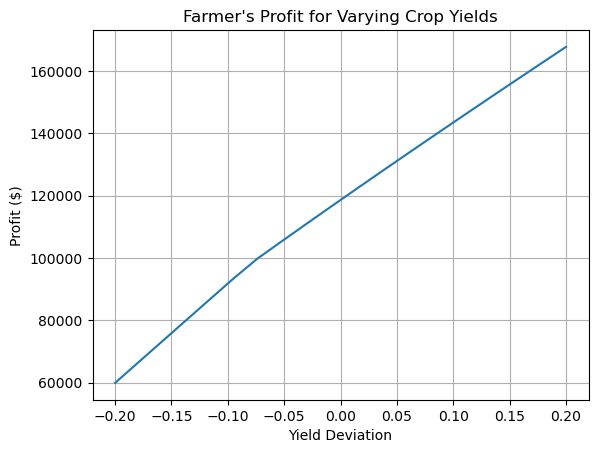

In [12]:
plt.plot(variations,obj_values)
plt.xlabel('Yield Deviation')
plt.ylabel('Profit ($)')
plt.grid()
plt.title("Farmer's Profit for Varying Crop Yields")
plt.show()

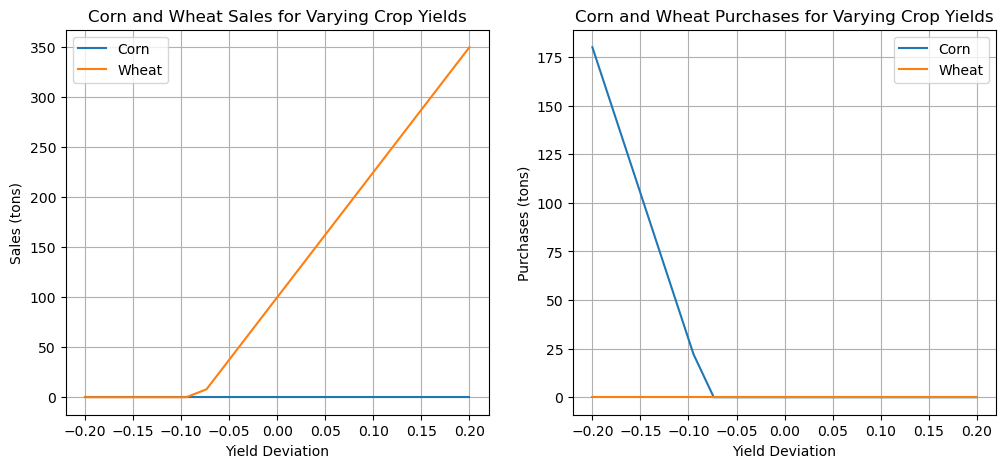

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(variations,sales['corn'],label='Corn')
plt.plot(variations,sales['wheat'],label='Wheat')
plt.xlabel('Yield Deviation')
plt.ylabel('Sales (tons)')
plt.grid()
plt.legend()
plt.title("Corn and Wheat Sales for Varying Crop Yields")

plt.subplot(1,2,2)
plt.plot(variations,purchases['corn'],label='Corn')
plt.plot(variations,purchases['wheat'],label='Wheat')
plt.xlabel('Yield Deviation')
plt.ylabel('Purchases (tons)')
plt.grid()
plt.legend()
plt.title("Corn and Wheat Purchases for Varying Crop Yields")
plt.show()


* Why do total sales increase with the yield? Why are purchases nonzero when yield is low?
* Why does the farmer decide to sell wheat and buy corn? For reference, the original data to the problem is pasted below:

|    | Wheat | Corn | Sugar Beets |
| -- | ----- | ---- | ----------- |
| Yield (ton/acre) | 2.5 | 3 | 20 |
| Planting cost (\\$/acre) | 150 | 230 | 260 |
| Selling price (\\$/ton) | 170 | 150| 36 under 6000 tons|
| | | | 10 above 6000 tons|
|Purchase price (\\$/ton) |238 | 210 |  |
| Minimum requirement (tons)| 200 | 240 | |

## Stochastic Recourse Problem Formulation
From the above sensitivity analysis, the Farmer concludes that his profit and optimal decisions are very sensitive to changing yields. This makes it difficult to make a perfect decision that would be best in all circumstances. To assess the benefits and losses of each decision in each scenario, he turns to a two-stage stochastic recourse model.

In this model, the decisions on land asignment ($x_1, x_2, x_3$) have to be taken now, while sales and purchase decisions $(w_i,~i = 1,\ldots, 4,~y_j,~j = 1,2$) depend on the yields. We refer to these decisions as "wait-and-see" decisions. For this stochastic model, we index these decisions by a scenario index $s = 1,2,3$ corresponding to the high-, medium- and low-yield scenarios, respectively. This creates a new set of variables:
- $w_{is}$ for $i =1,2,3,4$ and $s = 1,2,3$: tons of crop $i$ sold to the wholesale market in scenario $s$
- $y_{js}$ for $j = 1,2$ and $s = 1,2,3$: tons of crop $j$ purchased from the wholesale market in scenario $s$

For now, we will assume each scenario occurs with an equal probability of 1/3, but will relax this assumption later. As before, the farmer wants to maximize (expected) long-run profit. The LP formulation for the two-stage stochastic farmer's problem is:

$$
\begin{align*}
\min \quad & 150x_1 + 230x_2 + 260x_3 & \text{Planting costs}\\
            & - \sum_{s = 1}^3 \frac{1}{3}(170w_{1s} - 238y_{1s} + 150w_{2s} - 210y_{2s} + 36 w_{3s} + 10w_{4s}) & \text{Expected profit} \\
\text{s.t.}\quad & x_1 + x_2 + x_3 \leq 500 & \text{Total land available} \\
& 3x_1 + y_{11} - w_{11} \geq 200 & \text{Wheat min. requirement, $s = 1$}\\
& 3.6x_2 + y_{21} - w_{21} \geq 240 & \text{Corn min. requirement, $s = 1$}\\
& w_{31} + w_{41} - 24x_3 \leq 0 & \text{Sugar beets, $s = 1$}\\
& w_{31} \leq 6000 & \text{1st part of quota, $s=1$}\\
& 2.5x_1 + y_{12} - w_{12} \geq 200 & \text{Wheat min. requirement, $s = 2$}\\
& 3x_2 + y_{22} - w_{22} \geq 240 & \text{Corn min. requirement, $s = 2$}\\
& w_{32} + w_{42} - 20x_3 \leq 0 & \text{Sugar beets, $s = 2$}\\
& w_{32} \leq 6000 & \text{1st part of quota, $s=2$}\\
& 2x_1 + y_{13} - w_{13} \geq 200 & \text{Wheat min. requirement, $s = 3$}\\
& 2.4x_2 + y_{23} - w_{23} \geq 240 & \text{Corn min. requirement, $s = 3$}\\
& w_{33} + w_{43} - 16x_3 \leq 0 & \text{Sugar beets, $s = 3$}\\
& w_{33} \leq 600 & \text{1st part of quota, $s=3$}\\
&x, y, w \geq 0 & \text{Nonnegativity}
\end{align*}
$$

Run the cells below to implement and solve this model in Pyomo


In [14]:
# load scenario data
num_scenarios = 3
scenario_probabilities = {1: 1/3, 2: 1/3, 3:1/3}


yield_dict = {'low-yields':{'wheat': 2.0,
                            'corn': 2.4,
                            'sugar_beets': 16},
              'medium-yields':{'wheat': 2.5,
                              'corn': 3.0,
                              'sugar_beets': 20},
              'high-yields':{'wheat': 3.0,
                            'corn': 3.6,
                            'sugar_beets': 24}
              }




stoc_yields = {1: yield_dict['high-yields'],
               2: yield_dict['medium-yields'],
               3: yield_dict['low-yields']}

# create model instance
stoc_model = ConcreteModel(name='Stochastic Farmers Problem')

# set model parameters and sets
stoc_model.crops = Set(initialize=['wheat', 'corn','sugar_beets'])

stoc_model.scenarios = RangeSet(1,num_scenarios)

stoc_model.scenario_probs = Param(stoc_model.scenarios,
                                  initialize=scenario_probabilities,
                                  mutable=True)


# crop yields per acre (tons/acre)
stoc_model.yields = Param(stoc_model.crops, stoc_model.scenarios,
                          mutable=True, # let's us change the value later
                          initialize={(crop, s): stoc_yields[s][crop]
                                        for crop in stoc_model.crops
                                            for s in stoc_model.scenarios})

# planting costs (USD/acre)
stoc_model.planting_cost = Param(stoc_model.crops,
                                initialize=planting_costs)
# selling price in market (USD/ton)
stoc_model.selling_price = Param(['wheat', 'corn',
                             'sugar_beets_under_quota',
                             'sugar_beets_over_quota'],
                            initialize=selling_prices)

stoc_model.sugar_beets_quota = Param(initialize=sugar_beets_quota) # tons

# purchasing price at wholesaler
stoc_model.purchase_price = Param(['wheat', 'corn'],
                             initialize=purchase_prices) # USD/ton

# minimum requirement to feed cattle
stoc_model.minimum_req = Param(['wheat','corn'],
                          initialize=minimum_reqs) # acres
# total available acres
stoc_model.total_land = Param(initialize=total_land) # acres


In [15]:
# declare model variables

# first stage decisions
stoc_model.acres = Var(stoc_model.crops,# acres
                        within=NonNegativeReals)

# recourse decisions
stoc_model.sold = Var(['wheat', 'corn',
                       'sugar_beets_under_quota',
                       'sugar_beets_over_quota'], stoc_model.scenarios,
                        within=NonNegativeReals) # tons

stoc_model.purchased = Var(['wheat', 'corn'], stoc_model.scenarios, # tons
                      within=NonNegativeReals)

In [16]:
# set model constraints

# total land available constraint:
#   acres of wheat + acres of corn + acres of sugar_beets <= 500
stoc_model.total_land_constraint = Constraint(expr=sum(stoc_model.acres[crop] for crop in stoc_model.crops) <= stoc_model.total_land)

# wheat minimum requirement constraint:
#   yield + amount purchased - amount sold >= 200
def wheat_min_req_constraint_(m, s):
    return m.yields['wheat',s] * m.acres['wheat'] + m.purchased['wheat', s] - m.sold['wheat', s] >= m.minimum_req['wheat']

stoc_model.wheat_min_req_constraint = Constraint(stoc_model.scenarios, rule=wheat_min_req_constraint_)

# corn minimum requirement constraint:
#   yield + amount purchased - amount sold >= 240
def corn_min_req_constraint_(m, s):
    return m.yields['corn',s] * m.acres['corn'] + m.purchased['corn', s] - m.sold['corn', s] >= m.minimum_req['corn']
stoc_model.corn_min_req_constraint = Constraint(stoc_model.scenarios, rule=corn_min_req_constraint_)

# sugar beets selling constraint:
#   sugar_beets sold <= sugar_beet yield
def sugar_beets_sold_constraint_(m, s):
    return m.sold['sugar_beets_under_quota',s] + m.sold['sugar_beets_over_quota',s] <= m.yields['sugar_beets',s]*m.acres['sugar_beets']
stoc_model.sugar_beets_sold_constraint = Constraint(stoc_model.scenarios,rule=sugar_beets_sold_constraint_)

# sugar beets first quota constraint:
#   sugar_beets sold for under quota price <= 6000
def sugar_beets_quota_constraint_(m, s):
    return m.sold['sugar_beets_under_quota',s] <= m.sugar_beets_quota
stoc_model.sugar_beets_quota_constraint = Constraint(stoc_model.scenarios, rule=sugar_beets_quota_constraint_)


In [17]:
# set model objective
planting_costs = sum(stoc_model.planting_cost[crop]*stoc_model.acres[crop] for crop in stoc_model.crops)


def stoc_objective(m):

    obj = 0

    planting_costs = sum(stoc_model.planting_cost[crop]*stoc_model.acres[crop] for crop in stoc_model.crops)

    obj += planting_costs

    # expected profit
    for s in stoc_model.scenarios:
        purchase_costs = m.purchase_price['corn']*m.purchased['corn', s] \
                            + m.purchase_price['wheat']*m.purchased['wheat', s]

        revenue = m.selling_price['wheat']*m.sold['wheat', s] \
                    + m.selling_price['corn']*m.sold['corn', s] \
                    + m.selling_price['sugar_beets_under_quota']*m.sold['sugar_beets_under_quota', s] \
                    + m.selling_price['sugar_beets_over_quota']*m.sold['sugar_beets_over_quota', s]

        obj += m.scenario_probs[s]*(purchase_costs - revenue)

    return obj

stoc_model.objective = Objective(rule=stoc_objective, sense='minimize')

Run the cell below to solve the stochastic farmers problem.
- How does the farmer's profit compare to the one obtained in the deterministic cases?

In [18]:
# solve model
res = opt.solve(stoc_model,
                tee=False)

# check that solver status exited normally
assert res.solver.status == SolverStatus.ok, \
        f"Solver did not exit normally, termination condition {res.solver.status}."

# store recourse problem (RP) objective value
rp_obj_value = -stoc_model.objective()

print_stoc_solution(stoc_model)

=========== Stochastic Farmers Problem Solution Report =============

******** FARMERS PROFIT = $108390.00 


Wheat   Corn  Sugar Beets
Scenario Variable                                  
NA       Surface (acres) 170.00  80.00       250.00
1        Yield (tons)    510.00 288.00      6000.00
         Sales (tons)    310.00  48.00      6000.00
         Purchase (tons)   0.00   0.00         0.00
2        Yield (tons)    425.00 240.00      5000.00
         Sales (tons)    225.00   0.00      5000.00
         Purchase (tons)   0.00   0.00         0.00
3        Yield (tons)    340.00 192.00      4000.00
         Sales (tons)    140.00   0.00      4000.00
         Purchase (tons)  48.00  48.00         0.00

### Analyzing the Stochastic Solution
To analyze the solution to the two-stage recourse problem, we use two important notions in stochastic optimization: the value of the stochastic solution and expected value of perfect information.


#### Expected value of perfect information
The *expected value of perfect information (EVPI)* measures the maximum amount a decision maker would be ready to pay in return for complete (and accurate) information about the future. In the case of the Farmer's problem, the farmer would benefit from perfect information about future weather conditions, so that he could allocate his land optimally. To compute the EVPI, we first compute the expected value of the optimal solution, commonly referred to as the *wait-and-see* solution (WS). The EVPI is then the difference between this wait-and-see solution and the head-and-now solution (i.e., the original solution to the recourse problem): $$\text{EVPI} = \text{RP}-\text{WS}$$
Run the following cell to calculate the EVPI for the stochastic Farmer's problem.


In [19]:
def compute_evpi(scenario_probabilities, rp_obj_value, verbose=False):

    det_obj_values = dict()
    # compute deterministic solution with each yield scenario
    for yield_scenario, yield_data in yield_dict.items():
      # create instance of original deterministic model
      det_model_mod_yield = det_model.create_instance()


      # update yield values in model
      det_model_mod_yield.yields.store_values(yield_data)

      # solve model with changed data
      res = opt.solve(det_model_mod_yield)

      # check that solver status exited normally
      assert res.solver.status == SolverStatus.ok, \
              f"Solver did not exit normally, termination condition {res.solver.status}."

      det_obj_values[yield_scenario] = -det_model_mod_yield.objective()


    # compute wait-and-see (WS) solution by taking expected value
    ws_obj_value = (scenario_probabilities[1]*det_obj_values['high-yields']\
                        + scenario_probabilities[2]*det_obj_values['medium-yields']\
                        + scenario_probabilities[3]*det_obj_values['low-yields'])

    # compute expected value of perfect information (EVPI)
    evpi = ws_obj_value - rp_obj_value
    if verbose:
        print(f"Here-and-Now Solution (RP) = ${rp_obj_value:.2f}")
        print(f"Wait-and-See Solution (WS) = ${ws_obj_value:.2f}")
        print(f"Expected Value of Perfect Information: ${ws_obj_value:.2f} - ${rp_obj_value:.2f} = ${evpi:.2f}")

    return evpi
evpi = compute_evpi(scenario_probabilities,rp_obj_value,verbose=True)

Here-and-Now Solution (RP) = $108390.00
Wait-and-See Solution (WS) = $115405.56
Expected Value of Perfect Information: $115405.56 - $108390.00 = $7015.56


#### Value of the Stochastic Solution
A natural, yet naive, approach to stochastic modeling is to solve the problem with random variables replaced by their expected values, which is referred to as the expected value (EV) problem. The *value of the stochastic solution (VSS)* measures the difference between the expected result of using the EV solution (EVV) and the here-and-now solution to the recourse problem (RP):
$$ \text{VSS} = \text{EEV} - \text{RP}$$


Run the following cell to calculate the VSS for the stochastic Farmer's problem.


In [20]:
def compute_vss(scenario_probabilities, rp_obj_value, verbose=False):

    # Create instance of recourse problem
    recourse_problem = stoc_model.create_instance()

    # Update scenario probabilities
    recourse_problem.scenario_probs.store_values(scenario_probabilities)

    # Computed expected (mean) yields based on scenario probabilities
    avg_yields = {crop:sum(scenario_probabilities[s]*stoc_yields[s][crop] for s in recourse_problem.scenarios)
                        for crop in recourse_problem.crops}

    # Create expected value problem (EVP) by creating a copy of
    #   deterministic model
    exp_value_problem = det_model.create_instance()

    # Set yields in expected value problem to mean
    exp_value_problem.yields.store_values(avg_yields)

    # Solve expected value problem
    res = opt.solve(det_model)

    # check that solver status exited normally
    assert res.solver.status == SolverStatus.ok, \
            f"Solver did not exit normally, termination condition {res.solver.status}."

    # Fix first stage decisions in recourse problem based on solution from EVP
    recourse_problem.acres['wheat'].fix(exp_value_problem.acres['wheat'].value)
    recourse_problem.acres['corn'].fix(exp_value_problem.acres['corn'].value)
    recourse_problem.acres['sugar_beets'].fix(exp_value_problem.acres['sugar_beets'].value)

    # Solve recourse problem with first stage decisions fixed
    res = opt.solve(recourse_problem)
    # check that solver status exited normally
    assert res.solver.status == SolverStatus.ok, \
            f"Solver did not exit normally, termination condition {res.solver.status}."

    # Store expected result of using EVP solution (EEVP)
    eevp_obj_value = -recourse_problem.objective()

    # Compute value of the stochastic solution (VSS)
    vss = (rp_obj_value - eevp_obj_value)

    if verbose:
        print(f"Here-and-Now Solution (RP) = ${rp_obj_value:.2f}")
        print(f"Expected Result of EV Solution (EEV) = ${eevp_obj_value:.2f}")
        print(f"Value of the Stochastic Solution: ${rp_obj_value:.2f} - ${eevp_obj_value:.2f} = ${vss:.2f} ")

    return vss
vss = compute_vss(scenario_probabilities, rp_obj_value, verbose=True)


Here-and-Now Solution (RP) = $108390.00
Expected Result of EV Solution (EEV) = $107240.00
Value of the Stochastic Solution: $108390.00 - $107240.00 = $1150.00 


### Varying Scenario Probabilities (VSS and EVPI)

**Exercise 3 (JN-3):** Now, change the scenario probabilities and see what happens to the VSS and EVPI of our solution. Run the following cell to adjust the probabilities from $(1/3, 1/3, 1/3)$ to more extreme values (e.g., $(1/4, 1/4, 1/2)$).

In [21]:
# set scenario probabilities
scenario_probabilities = {1: 1/3, # modifiy me!
                          2: 1/3, # modifiy me!
                          3: 1/3} # modifiy me!

# check that probabilities sum to 1
assert sum(scenario_probabilities[s] for s in stoc_model.scenarios) == 1,\
        "Scenario probabilities do not sum to one. Try again!"

Now, run the cell below to solve the stochastic version of the Farmer's problem with these new probabilities (make sure you've run the above cell so your changes take place!)
- What happens to the VSS and EVPI? Do they change? If so, why do you think?

In [22]:
# create new instance of recourse problem
temp_recourse_problem = stoc_model.create_instance()

temp_recourse_problem.scenario_probs.store_values(scenario_probabilities)

res = opt.solve(temp_recourse_problem)

temp_rp_obj_value = -temp_recourse_problem.objective()

vss = compute_vss(scenario_probabilities, temp_rp_obj_value)
evpi = compute_evpi(scenario_probabilities, temp_rp_obj_value)

print(f"Scenario Probabilities: {scenario_probabilities}")
print(f"Value of the Stochastic Solution (VSS) = ${vss:.2f}")
print(f"Expected Value of Perfect Information (EVPI) = ${evpi:.2f}")

Scenario Probabilities: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}
Value of the Stochastic Solution (VSS) = $1150.00
Expected Value of Perfect Information (EVPI) = $7015.56


### Scenario Probabilities Sensitivity Analysis

Now, let's conduct a more robust sensitivity analysis by varying the scenario probabilities. Run the cells below to skew the distribution by a sequence of skew factors $k$. Can you jusify the trends you see?


In [23]:
# helper function that skews probability distribution
def skew_distribution(k):
    x = np.array([1.0, 2.0, 3.0])
    exponentials = np.exp(k * x)
    return exponentials / np.sum(exponentials)

# help function to compute entropy of distribution
def compute_entropy(dist):
    return - np.sum(np.multiply(dist,np.log(dist)))


skews = np.linspace(-3,3,50)
entropies = np.zeros_like(skews)
results = {'VSS': np.zeros_like(skews), 'EVPI': np.zeros_like(skews)}
for i, k in np.ndenumerate(skews):

    # create model instance
    temp_recourse_problem = stoc_model.create_instance()

    # skew distribution
    distribution = skew_distribution(k)

    scenario_probabilities = dict(zip(stoc_model.scenarios,distribution))

    temp_recourse_problem.scenario_probs.store_values(scenario_probabilities)

    res = opt.solve(temp_recourse_problem)

    temp_rp_obj_value = -temp_recourse_problem.objective()

    results['VSS'][i] = compute_vss(scenario_probabilities, temp_rp_obj_value)
    results['EVPI'][i] = compute_evpi(scenario_probabilities, temp_rp_obj_value)
    entropies[i] = compute_entropy(distribution)



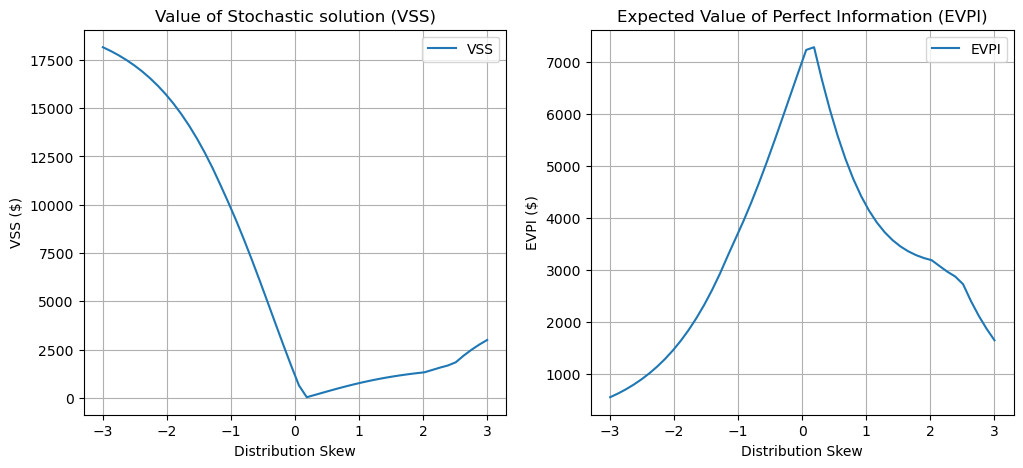

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(skews,results['VSS'],label='VSS')
plt.xlabel('Distribution Skew')
plt.ylabel('VSS ($)')
plt.grid()
plt.legend()
plt.title("Value of Stochastic solution (VSS)")

plt.subplot(1,2,2)
plt.plot(skews,results['EVPI'],label='EVPI')
plt.xlabel('Distribution Skew')
plt.ylabel('EVPI ($)')
plt.grid()
plt.legend()
plt.title("Expected Value of Perfect Information (EVPI)")
plt.show()